In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)

# Part 1

In [60]:
def lotka(x, y, alpha, beta, delta, gamma):
    '''Calculate the Lotka-Volterra ODE.

    Inputs: scalar or tensor values, as per the original formula.
    Outputs: scalar our tensor x' and y'.
    ''' 
    x , y = tf.Variable(x,dtype=tf.float32),  tf.Variable(y,dtype=tf.float32)
    x_prime = tf.subtract(tf.multiply(alpha,x), tf.multiply(tf.multiply(beta,x),y))
    y_prime = tf.subtract(tf.multiply(tf.multiply(delta,x),y), tf.multiply(gamma, y))
    return x_prime, y_prime


def integrate_ode(x0, y0, alpha, beta, delta, gamma, time, dt):
    '''Integrate the ODE.

    Inputs: initial conditions x0 and y0, hyperparameters:
    alpha, beta, delta, gamma; total time to integrate; discretization
    step dt.

    Outputs: two tensors containing x[t] and y[t]
    '''
    x , y = [], []

    x_t = x0
    y_t = y0

    for i in range(round(time/dt)):
        x_t = x_t + dt * lotka(x_t, y_t,alpha, beta, delta, gamma)[0]
        y_t = y_t + dt * lotka(x_t, y_t,alpha, beta, delta, gamma)[1]
        x.append(x_t)
        y.append(y_t)

    return tf.Variable(x), tf.Variable(y)

x, y = integrate_ode(5, 4, 0.9, 0.3, 0.8, 1, 20, 0.01)

Text(0.5, 0, 'x')

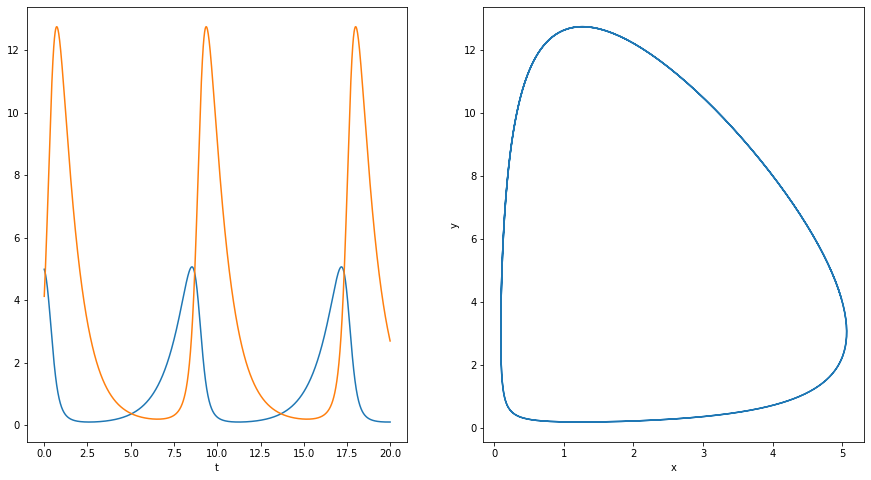

In [61]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(np.arange(0,20,0.01),x.numpy())
plt.plot(np.arange(0,20,0.01),y.numpy())
plt.xlabel('t')

plt.subplot(1,2,2)
plt.plot(x.numpy(),y.numpy())
plt.ylabel('y')
plt.xlabel('x')

# Part 2

In [2]:
df = pd.read_csv("https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv")

df.head()

,t,x,y
0,0.00,-,0.5759052335487023
1,0.01,-,-
2,0.02,1.1159124144549086,-
3,0.03,-,-
4,0.04,1.0054825084650338,0.4775267298487888


In [3]:
df['x'] = df['x'].apply(lambda x: np.nan if x == "-" else x)
df['y'] = df['y'].apply(lambda x: np.nan if x == "-" else x)

In [4]:
df.x = df.x.astype('float32')
df.y = df.y.astype('float32')
df.head()

,t,x,y
0,0.00,NaN,0.575905
1,0.01,NaN,NaN
2,0.02,1.115912,NaN
3,0.03,NaN,NaN
4,0.04,1.005483,0.477527


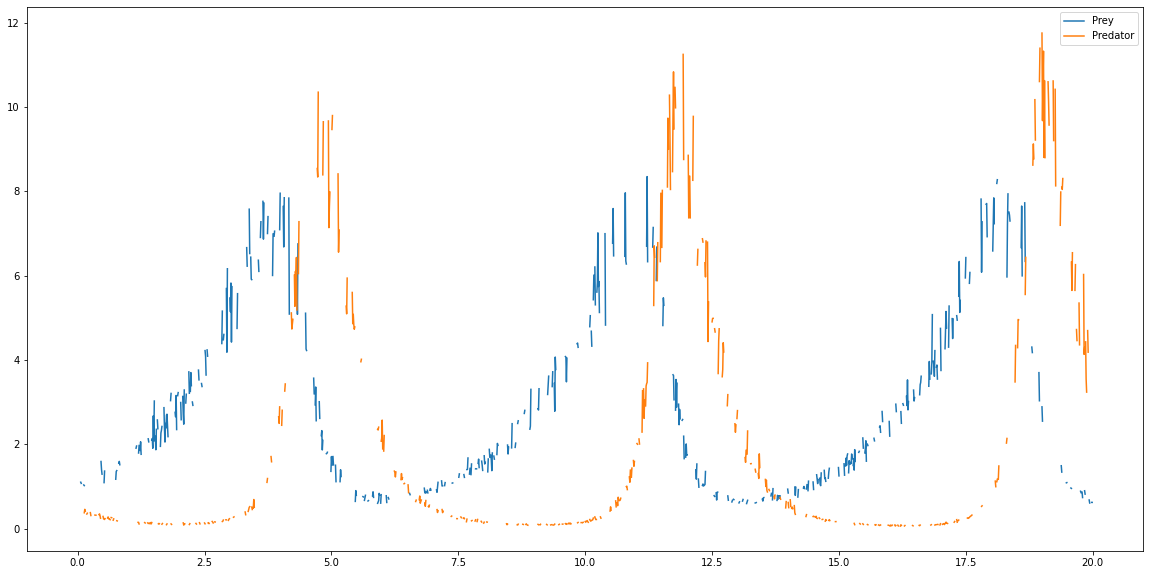

In [5]:
plt.figure(figsize=(20,10))
plt.plot(df['t'],df['x'], label="Prey")
plt.plot(df['t'],df['y'], label="Predator")
plt.legend();

In [6]:
df.dropna(inplace=True,thresh=3)
df.head()

,t,x,y
4,0.04,1.005483,0.477527
6,0.06,1.101832,0.460175
13,0.13,1.020803,0.376706
18,0.18,1.165619,0.345918
30,0.30,1.161122,0.397953


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def process_df(df):
    # Feature generation
    df['sin'] = df['t'].apply(lambda x: np.sin(x))
    df['cos'] = df['t'].apply(lambda x: np.cos(x))
    df['tan'] = df['t'].apply(lambda x: np.tan(x))
  
    scaler = StandardScaler()
    df[['t','sin','cos','tan']] = scaler.fit_transform(df[['t','sin','cos','tan']])
  
    x_train, x_test, y_train, y_test = train_test_split(df[['t','sin','cos','tan']],
                                                  df[['x','y']],
                                                  test_size=20,
                                                  random_state=42)

    
    
    return x_train, x_test, y_train, y_test

In [8]:
x_train, x_test, y_train, y_test = process_df(df)

### Fitting a basic model to gauge performance

In [9]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                              verbose = 0,
                                              save_best_only=True
                                             )
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(layers.Dense(150, activation = "relu"))
model.add(layers.Dense(20, activation = "tanh"))
model.add(layers.Dense(2, activation="linear"))

model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.losses.mae,tf.keras.losses.mse]
             )

history = model.fit(x_train, 
          y_train, 
          epochs = 300, 
          validation_data = (x_test,
                             y_test),
          callbacks = [lr_scheduler],
          batch_size = 32
         )

Epoch 1/300
10/10 [==============================] - 0s 11ms/step - loss: 2.4116 - mean_absolute_error: 2.4116 - mean_squared_error: 12.8054 - val_loss: 1.8791 - val_mean_absolute_error: 1.8791 - val_mean_squared_error: 9.4628 - lr: 1.0000e-04
Epoch 2/300
10/10 [==============================] - 0s 2ms/step - loss: 2.3599 - mean_absolute_error: 2.3599 - mean_squared_error: 12.4824 - val_loss: 1.8256 - val_mean_absolute_error: 1.8256 - val_mean_squared_error: 9.1861 - lr: 1.1220e-04
Epoch 3/300
10/10 [==============================] - 0s 260us/step - loss: 2.3020 - mean_absolute_error: 2.3020 - mean_squared_error: 12.1323 - val_loss: 1.7659 - val_mean_absolute_error: 1.7659 - val_mean_squared_error: 8.8867 - lr: 1.2589e-04
Epoch 4/300
10/10 [==============================] - 0s 249us/step - loss: 2.2376 - mean_absolute_error: 2.2376 - mean_squared_error: 11.7466 - val_loss: 1.6986 - val_mean_absolute_error: 1.6986 - val_mean_squared_error: 8.5605 - lr: 1.4125e-04
Epoch 5/300
10/10 [====

Epoch 35/300
10/10 [==============================] - 0s 279us/step - loss: 0.5330 - mean_absolute_error: 0.5330 - mean_squared_error: 1.0210 - val_loss: 0.5664 - val_mean_absolute_error: 0.5664 - val_mean_squared_error: 1.1095 - lr: 0.0050
Epoch 36/300
10/10 [==============================] - 0s 2ms/step - loss: 0.4938 - mean_absolute_error: 0.4938 - mean_squared_error: 0.8484 - val_loss: 0.5176 - val_mean_absolute_error: 0.5176 - val_mean_squared_error: 1.3216 - lr: 0.0056
Epoch 37/300
10/10 [==============================] - 0s 2ms/step - loss: 0.4349 - mean_absolute_error: 0.4349 - mean_squared_error: 0.6246 - val_loss: 0.5523 - val_mean_absolute_error: 0.5523 - val_mean_squared_error: 1.0957 - lr: 0.0063
Epoch 38/300
10/10 [==============================] - 0s 547us/step - loss: 0.3954 - mean_absolute_error: 0.3954 - mean_squared_error: 0.4666 - val_loss: 0.5201 - val_mean_absolute_error: 0.5201 - val_mean_squared_error: 0.9091 - lr: 0.0071
Epoch 39/300
10/10 [====================

10/10 [==============================] - 0s 451us/step - loss: 0.9770 - mean_absolute_error: 0.9770 - mean_squared_error: 1.8030 - val_loss: 1.0279 - val_mean_absolute_error: 1.0279 - val_mean_squared_error: 1.5395 - lr: 0.2512
Epoch 70/300
10/10 [==============================] - 0s 2ms/step - loss: 1.0936 - mean_absolute_error: 1.0936 - mean_squared_error: 2.5344 - val_loss: 1.8546 - val_mean_absolute_error: 1.8546 - val_mean_squared_error: 5.6589 - lr: 0.2818
Epoch 71/300
10/10 [==============================] - 0s 2ms/step - loss: 1.1115 - mean_absolute_error: 1.1115 - mean_squared_error: 2.2535 - val_loss: 1.2179 - val_mean_absolute_error: 1.2179 - val_mean_squared_error: 2.1119 - lr: 0.3162
Epoch 72/300
10/10 [==============================] - 0s 2ms/step - loss: 1.5300 - mean_absolute_error: 1.5300 - mean_squared_error: 4.2173 - val_loss: 1.2017 - val_mean_absolute_error: 1.2017 - val_mean_squared_error: 2.1404 - lr: 0.3548
Epoch 73/300
10/10 [==============================] - 0

Epoch 103/300
10/10 [==============================] - 0s 2ms/step - loss: 37.9726 - mean_absolute_error: 37.9726 - mean_squared_error: 2038.7717 - val_loss: 22.0686 - val_mean_absolute_error: 22.0686 - val_mean_squared_error: 819.5174 - lr: 12.5893
Epoch 104/300
10/10 [==============================] - 0s 673us/step - loss: 38.0886 - mean_absolute_error: 38.0886 - mean_squared_error: 2292.3992 - val_loss: 58.0437 - val_mean_absolute_error: 58.0437 - val_mean_squared_error: 5785.5498 - lr: 14.1254
Epoch 105/300
10/10 [==============================] - 0s 366us/step - loss: 61.6079 - mean_absolute_error: 61.6079 - mean_squared_error: 5240.5454 - val_loss: 61.4363 - val_mean_absolute_error: 61.4363 - val_mean_squared_error: 5170.7891 - lr: 15.8489
Epoch 106/300
10/10 [==============================] - 0s 2ms/step - loss: 90.3501 - mean_absolute_error: 90.3501 - mean_squared_error: 10570.6592 - val_loss: 103.1333 - val_mean_absolute_error: 103.1333 - val_mean_squared_error: 11739.6953 - l

Epoch 135/300
10/10 [==============================] - 0s 895us/step - loss: 916.0814 - mean_absolute_error: 916.0814 - mean_squared_error: 1348102.6250 - val_loss: 1404.1862 - val_mean_absolute_error: 1404.1862 - val_mean_squared_error: 2509857.5000 - lr: 501.1872
Epoch 136/300
10/10 [==============================] - 0s 2ms/step - loss: 1061.7273 - mean_absolute_error: 1061.7273 - mean_squared_error: 1644776.1250 - val_loss: 700.0933 - val_mean_absolute_error: 700.0933 - val_mean_squared_error: 584614.1875 - lr: 562.3413
Epoch 137/300
10/10 [==============================] - 0s 2ms/step - loss: 866.7505 - mean_absolute_error: 866.7505 - mean_squared_error: 1070190.7500 - val_loss: 691.6000 - val_mean_absolute_error: 691.6000 - val_mean_squared_error: 636765.3750 - lr: 630.9573
Epoch 138/300
10/10 [==============================] - 0s 2ms/step - loss: 801.5329 - mean_absolute_error: 801.5329 - mean_squared_error: 914100.2500 - val_loss: 996.9225 - val_mean_absolute_error: 996.9225 - v

10/10 [==============================] - 0s 2ms/step - loss: 26703.8008 - mean_absolute_error: 26703.8008 - mean_squared_error: 1106194688.0000 - val_loss: 31121.9316 - val_mean_absolute_error: 31121.9316 - val_mean_squared_error: 1227571200.0000 - lr: 15848.9316
Epoch 166/300
10/10 [==============================] - 0s 263us/step - loss: 41011.9102 - mean_absolute_error: 41011.9102 - mean_squared_error: 2266505472.0000 - val_loss: 57489.2578 - val_mean_absolute_error: 57489.2578 - val_mean_squared_error: 4436133376.0000 - lr: 17782.7949
Epoch 167/300
10/10 [==============================] - 0s 3ms/step - loss: 51624.8516 - mean_absolute_error: 51624.8516 - mean_squared_error: 4211981568.0000 - val_loss: 20887.2148 - val_mean_absolute_error: 20887.2148 - val_mean_squared_error: 559414272.0000 - lr: 19952.6230
Epoch 168/300
10/10 [==============================] - 0s 2ms/step - loss: 48839.3516 - mean_absolute_error: 48839.3516 - mean_squared_error: 3298564352.0000 - val_loss: 59841.375

Epoch 194/300
10/10 [==============================] - 0s 2ms/step - loss: 383708.8125 - mean_absolute_error: 383708.8125 - mean_squared_error: 218981236736.0000 - val_loss: 242730.0469 - val_mean_absolute_error: 242730.0469 - val_mean_squared_error: 200873443328.0000 - lr: 446683.5938
Epoch 195/300
10/10 [==============================] - 0s 271us/step - loss: 904986.0625 - mean_absolute_error: 904986.0625 - mean_squared_error: 1261349765120.0000 - val_loss: 113269.3984 - val_mean_absolute_error: 113269.3984 - val_mean_squared_error: 20492429312.0000 - lr: 501187.2188
Epoch 196/300
10/10 [==============================] - 0s 2ms/step - loss: 731370.1250 - mean_absolute_error: 731370.1250 - mean_squared_error: 743193640960.0000 - val_loss: 993088.1875 - val_mean_absolute_error: 993088.1875 - val_mean_squared_error: 1134915354624.0000 - lr: 562341.3125
Epoch 197/300
10/10 [==============================] - 0s 1ms/step - loss: 1003610.5000 - mean_absolute_error: 1003610.5000 - mean_squar

Epoch 222/300
10/10 [==============================] - 0s 298us/step - loss: 24741792.0000 - mean_absolute_error: 24741792.0000 - mean_squared_error: 868922819608576.0000 - val_loss: 7248645.0000 - val_mean_absolute_error: 7248645.0000 - val_mean_squared_error: 88053515288576.0000 - lr: 11220185.0000
Epoch 223/300
10/10 [==============================] - 0s 2ms/step - loss: 14933622.0000 - mean_absolute_error: 14933622.0000 - mean_squared_error: 398768520298496.0000 - val_loss: 37772772.0000 - val_mean_absolute_error: 37772772.0000 - val_mean_squared_error: 1599209195175936.0000 - lr: 12589254.0000
Epoch 224/300
10/10 [==============================] - 0s 2ms/step - loss: 28210746.0000 - mean_absolute_error: 28210746.0000 - mean_squared_error: 1229447676035072.0000 - val_loss: 20045872.0000 - val_mean_absolute_error: 20045872.0000 - val_mean_squared_error: 503020999671808.0000 - lr: 14125375.0000
Epoch 225/300
10/10 [==============================] - 0s 562us/step - loss: 38982144.0000

10/10 [==============================] - 0s 2ms/step - loss: 529849312.0000 - mean_absolute_error: 529849312.0000 - mean_squared_error: 374370274600026112.0000 - val_loss: 330691296.0000 - val_mean_absolute_error: 330691296.0000 - val_mean_squared_error: 138738988532891648.0000 - lr: 223872112.0000
Epoch 249/300
10/10 [==============================] - 0s 2ms/step - loss: 311884768.0000 - mean_absolute_error: 311884768.0000 - mean_squared_error: 158928839517405184.0000 - val_loss: 536985920.0000 - val_mean_absolute_error: 536985920.0000 - val_mean_squared_error: 436419907643506688.0000 - lr: 251188640.0000
Epoch 250/300
10/10 [==============================] - 0s 1ms/step - loss: 635916544.0000 - mean_absolute_error: 635916544.0000 - mean_squared_error: 719447497851797504.0000 - val_loss: 363780192.0000 - val_mean_absolute_error: 363780192.0000 - val_mean_squared_error: 197106150976520192.0000 - lr: 281838304.0000
Epoch 251/300
10/10 [==============================] - 0s 287us/step - l

Epoch 274/300
10/10 [==============================] - 0s 515us/step - loss: 8591321088.0000 - mean_absolute_error: 8591321088.0000 - mean_squared_error: 100468666636403998720.0000 - val_loss: 2908067072.0000 - val_mean_absolute_error: 2908067072.0000 - val_mean_squared_error: 16229460129043447808.0000 - lr: 4466835968.0000
Epoch 275/300
10/10 [==============================] - 0s 441us/step - loss: 9759706112.0000 - mean_absolute_error: 9759706112.0000 - mean_squared_error: 148356382656187858944.0000 - val_loss: 9370612736.0000 - val_mean_absolute_error: 9370612736.0000 - val_mean_squared_error: 118217854145173389312.0000 - lr: 5011872256.0000
Epoch 276/300
10/10 [==============================] - 0s 2ms/step - loss: 6158262272.0000 - mean_absolute_error: 6158262272.0000 - mean_squared_error: 56353568525566083072.0000 - val_loss: 14127959040.0000 - val_mean_absolute_error: 14127959040.0000 - val_mean_squared_error: 209399051614869782528.0000 - lr: 5623413248.0000
Epoch 277/300
10/10 [

Epoch 299/300
10/10 [==============================] - 0s 2ms/step - loss: 150214328320.0000 - mean_absolute_error: 150214328320.0000 - mean_squared_error: 36774241836485587238912.0000 - val_loss: 161971863552.0000 - val_mean_absolute_error: 161971863552.0000 - val_mean_squared_error: 45386687073088673153024.0000 - lr: 79432826880.0000
Epoch 300/300
10/10 [==============================] - 0s 2ms/step - loss: 97683759104.0000 - mean_absolute_error: 97683759104.0000 - mean_squared_error: 15958149495216790306816.0000 - val_loss: 43240042496.0000 - val_mean_absolute_error: 43240042496.0000 - val_mean_squared_error: 2870825493441833598976.0000 - lr: 89125093376.0000


In [11]:
perf = pd.DataFrame(history.history)

display(perf.loc[perf["val_loss"]==min(perf["val_loss"])])

best_lr = perf.loc[perf["val_loss"]==min(perf["val_loss"])]['lr'].values[0]


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr
43,0.381872,0.381872,0.312568,0.324842,0.324842,0.247655,0.014125


In [12]:
from tensorflow.keras import layers
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(layers.Dense(150, activation = "relu"))
model.add(layers.Dense(20, activation = "tanh"))
model.add(layers.Dense(2, activation="linear"))

model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate = best_lr),
              metrics=[tf.keras.losses.mae,tf.keras.losses.mse]
             )

history = model.fit(x_train, 
          y_train, 
          epochs = 300, 
          validation_data = (x_test,
                             y_test),
          callbacks = [create_model_checkpoint("model_1")],
          batch_size = 32
         )

Epoch 1/300
10/10 [==============================] - 1s 41ms/step - loss: 1.4723 - mean_absolute_error: 1.4723 - mean_squared_error: 6.0003 - val_loss: 0.9805 - val_mean_absolute_error: 0.9805 - val_mean_squared_error: 2.7385
Epoch 2/300
10/10 [==============================] - 0s 28ms/step - loss: 1.0994 - mean_absolute_error: 1.0994 - mean_squared_error: 3.2114 - val_loss: 0.7238 - val_mean_absolute_error: 0.7238 - val_mean_squared_error: 2.0966
Epoch 3/300
10/10 [==============================] - 0s 36ms/step - loss: 0.8855 - mean_absolute_error: 0.8855 - mean_squared_error: 2.4692 - val_loss: 0.7040 - val_mean_absolute_error: 0.7040 - val_mean_squared_error: 1.8806
Epoch 4/300
10/10 [==============================] - 0s 28ms/step - loss: 0.7040 - mean_absolute_error: 0.7040 - mean_squared_error: 1.6798 - val_loss: 0.6353 - val_mean_absolute_error: 0.6353 - val_mean_squared_error: 1.5505
Epoch 5/300
10/10 [==============================] - 0s 28ms/step - loss: 0.6217 - mean_absolute

Epoch 28/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2704 - mean_absolute_error: 0.2704 - mean_squared_error: 0.2047 - val_loss: 0.4024 - val_mean_absolute_error: 0.4024 - val_mean_squared_error: 0.5755
Epoch 29/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2819 - mean_absolute_error: 0.2819 - mean_squared_error: 0.2345 - val_loss: 0.3095 - val_mean_absolute_error: 0.3095 - val_mean_squared_error: 0.3830
Epoch 30/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2940 - mean_absolute_error: 0.2940 - mean_squared_error: 0.2368 - val_loss: 0.3706 - val_mean_absolute_error: 0.3706 - val_mean_squared_error: 0.4803
Epoch 31/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2693 - mean_absolute_error: 0.2693 - mean_squared_error: 0.1902 - val_loss: 0.2585 - val_mean_absolute_error: 0.2585 - val_mean_squared_error: 0.2062
Epoch 32/300
10/10 [==============================] - 0s 1ms/step - loss: 0.2657 - mean_absolute

10/10 [==============================] - 0s 28ms/step - loss: 0.2354 - mean_absolute_error: 0.2354 - mean_squared_error: 0.1637 - val_loss: 0.2127 - val_mean_absolute_error: 0.2127 - val_mean_squared_error: 0.1377
Epoch 63/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2349 - mean_absolute_error: 0.2349 - mean_squared_error: 0.1637 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495 - val_mean_squared_error: 0.1516
Epoch 64/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2506 - mean_absolute_error: 0.2506 - mean_squared_error: 0.1803 - val_loss: 0.2425 - val_mean_absolute_error: 0.2425 - val_mean_squared_error: 0.1673
Epoch 65/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2197 - mean_absolute_error: 0.2197 - mean_squared_error: 0.1552 - val_loss: 0.2287 - val_mean_absolute_error: 0.2287 - val_mean_squared_error: 0.1489
Epoch 66/300
10/10 [==============================] - 0s 27ms/step - loss: 0.2146 - mean_absolute_error: 0.2

Epoch 95/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2220 - mean_absolute_error: 0.2220 - mean_squared_error: 0.1416 - val_loss: 0.2655 - val_mean_absolute_error: 0.2655 - val_mean_squared_error: 0.2230
Epoch 96/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2157 - mean_absolute_error: 0.2157 - mean_squared_error: 0.1312 - val_loss: 0.2695 - val_mean_absolute_error: 0.2695 - val_mean_squared_error: 0.2495
Epoch 97/300
10/10 [==============================] - 0s 340us/step - loss: 0.2323 - mean_absolute_error: 0.2323 - mean_squared_error: 0.1509 - val_loss: 0.2492 - val_mean_absolute_error: 0.2492 - val_mean_squared_error: 0.1513
Epoch 98/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2278 - mean_absolute_error: 0.2278 - mean_squared_error: 0.1500 - val_loss: 0.2673 - val_mean_absolute_error: 0.2673 - val_mean_squared_error: 0.2283
Epoch 99/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2206 - mean_absolu

10/10 [==============================] - 0s 2ms/step - loss: 0.2010 - mean_absolute_error: 0.2010 - mean_squared_error: 0.1244 - val_loss: 0.2605 - val_mean_absolute_error: 0.2605 - val_mean_squared_error: 0.1795
Epoch 132/300
10/10 [==============================] - 0s 673us/step - loss: 0.2044 - mean_absolute_error: 0.2044 - mean_squared_error: 0.1279 - val_loss: 0.2888 - val_mean_absolute_error: 0.2888 - val_mean_squared_error: 0.2998
Epoch 133/300
10/10 [==============================] - 0s 389us/step - loss: 0.2107 - mean_absolute_error: 0.2107 - mean_squared_error: 0.1274 - val_loss: 0.2227 - val_mean_absolute_error: 0.2227 - val_mean_squared_error: 0.1604
Epoch 134/300
10/10 [==============================] - 0s 2ms/step - loss: 0.1979 - mean_absolute_error: 0.1979 - mean_squared_error: 0.1254 - val_loss: 0.2461 - val_mean_absolute_error: 0.2461 - val_mean_squared_error: 0.1628
Epoch 135/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2253 - mean_absolute_erro

10/10 [==============================] - 0s 966us/step - loss: 0.1896 - mean_absolute_error: 0.1896 - mean_squared_error: 0.1161 - val_loss: 0.2205 - val_mean_absolute_error: 0.2205 - val_mean_squared_error: 0.1606
Epoch 167/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1895 - mean_absolute_error: 0.1895 - mean_squared_error: 0.1167 - val_loss: 0.2108 - val_mean_absolute_error: 0.2108 - val_mean_squared_error: 0.1460
Epoch 168/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2024 - mean_absolute_error: 0.2024 - mean_squared_error: 0.1249 - val_loss: 0.2239 - val_mean_absolute_error: 0.2239 - val_mean_squared_error: 0.1635
Epoch 169/300
10/10 [==============================] - 0s 2ms/step - loss: 0.1942 - mean_absolute_error: 0.1942 - mean_squared_error: 0.1158 - val_loss: 0.2756 - val_mean_absolute_error: 0.2756 - val_mean_squared_error: 0.2266
Epoch 170/300
10/10 [==============================] - 0s 669us/step - loss: 0.2058 - mean_absolute_erro

10/10 [==============================] - 0s 147us/step - loss: 0.2084 - mean_absolute_error: 0.2084 - mean_squared_error: 0.1311 - val_loss: 0.2845 - val_mean_absolute_error: 0.2845 - val_mean_squared_error: 0.3475
Epoch 203/300
10/10 [==============================] - 0s 2ms/step - loss: 0.1986 - mean_absolute_error: 0.1986 - mean_squared_error: 0.1226 - val_loss: 0.2893 - val_mean_absolute_error: 0.2893 - val_mean_squared_error: 0.4587
Epoch 204/300
10/10 [==============================] - 0s 2ms/step - loss: 0.1886 - mean_absolute_error: 0.1886 - mean_squared_error: 0.1130 - val_loss: 0.3124 - val_mean_absolute_error: 0.3124 - val_mean_squared_error: 0.5494
Epoch 205/300
10/10 [==============================] - 0s 451us/step - loss: 0.1856 - mean_absolute_error: 0.1856 - mean_squared_error: 0.1181 - val_loss: 0.3311 - val_mean_absolute_error: 0.3311 - val_mean_squared_error: 0.5492
Epoch 206/300
10/10 [==============================] - 0s 113us/step - loss: 0.1939 - mean_absolute_er

10/10 [==============================] - 0s 2ms/step - loss: 0.2004 - mean_absolute_error: 0.2004 - mean_squared_error: 0.1222 - val_loss: 0.2760 - val_mean_absolute_error: 0.2760 - val_mean_squared_error: 0.3485
Epoch 239/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2057 - mean_absolute_error: 0.2057 - mean_squared_error: 0.1320 - val_loss: 0.2546 - val_mean_absolute_error: 0.2546 - val_mean_squared_error: 0.3529
Epoch 240/300
10/10 [==============================] - 0s 451us/step - loss: 0.2179 - mean_absolute_error: 0.2179 - mean_squared_error: 0.1413 - val_loss: 0.2457 - val_mean_absolute_error: 0.2457 - val_mean_squared_error: 0.2188
Epoch 241/300
10/10 [==============================] - 0s 154us/step - loss: 0.2137 - mean_absolute_error: 0.2137 - mean_squared_error: 0.1538 - val_loss: 0.2243 - val_mean_absolute_error: 0.2243 - val_mean_squared_error: 0.1666
Epoch 242/300
10/10 [==============================] - 0s 2ms/step - loss: 0.1980 - mean_absolute_erro

10/10 [==============================] - 0s 304us/step - loss: 0.1919 - mean_absolute_error: 0.1919 - mean_squared_error: 0.1149 - val_loss: 0.2550 - val_mean_absolute_error: 0.2550 - val_mean_squared_error: 0.2293
Epoch 275/300
10/10 [==============================] - 0s 2ms/step - loss: 0.2064 - mean_absolute_error: 0.2064 - mean_squared_error: 0.1414 - val_loss: 0.2176 - val_mean_absolute_error: 0.2176 - val_mean_squared_error: 0.1590
Epoch 276/300
10/10 [==============================] - 0s 2ms/step - loss: 0.1961 - mean_absolute_error: 0.1961 - mean_squared_error: 0.1268 - val_loss: 0.2192 - val_mean_absolute_error: 0.2192 - val_mean_squared_error: 0.1579
Epoch 277/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1867 - mean_absolute_error: 0.1867 - mean_squared_error: 0.1200 - val_loss: 0.2605 - val_mean_absolute_error: 0.2605 - val_mean_squared_error: 0.2391
Epoch 278/300
10/10 [==============================] - 0s 178us/step - loss: 0.1926 - mean_absolute_erro

In [13]:
loss = pd.DataFrame(history.history)
loss.loc[loss['val_loss']==min(loss['val_loss'])]

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
144,0.199465,0.199465,0.120426,0.192594,0.192594,0.102864


In [14]:
test_pred = model.predict(df[int(0.8*len(df)):][['t','sin','cos','tan']])
actual = df[int(0.8*len(df)):][['x','y','t']].values
model = tf.keras.models.load_model("model_experiments/model_1/")
train_pred = model.predict(df[:int(0.8*len(df))][['t','sin','cos','tan']])
test_pred = model.predict(df[int(0.8*len(df)):][['t','sin','cos','tan']])

In [15]:
test_loss = pd.DataFrame({'x_pred':test_pred[:,0], 
              'x_actual':actual[:,0],
              'y_pred':test_pred[:,1],
              'y_actual':actual[:,1],
              "t":actual[:,2]
              })

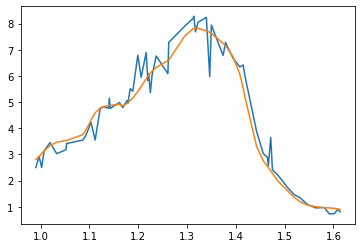

In [16]:
plt.plot(test_loss.t, test_loss.x_actual)
plt.plot(test_loss.t, test_loss.x_pred)

In [17]:
actual = df[:int(0.8*len(df))][['x','y','t']].values
train_loss = pd.DataFrame({'x_pred':train_pred[:,0], 
              'x_actual':actual[:,0],
              'y_pred':train_pred[:,1],
              'y_actual':actual[:,1],
              "t":actual[:,2]
              })

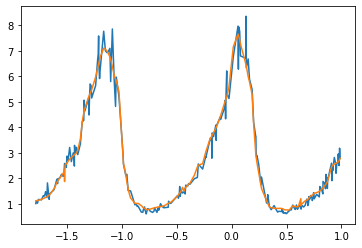

In [18]:
plt.plot(train_loss.t, train_loss.x_actual)
plt.plot(train_loss.t, train_loss.x_pred)

### We see that the model is fitting the data

<b>Overfitting is present, but it is acceptable in this case of missing value imputation</b>

### Tuning Hyperparams

In [19]:
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

In [20]:
def build_model(hp):
    model = tf.keras.Sequential()
    for i in range(hp.Int('num_layers',2,8)):
        model.add(layers.Dense(units=hp.Int('units_'+str(i),
                                            min_value = 32,
                                            max_value = 512,
                                            step = 32,
                                            
                                           ),
                               activation=hp.Choice('act_' + str(i),
                                                                  ['elu','relu', 'sigmoid','tanh'])
                              )
                 )
        model.add(layers.Dense(units=hp.Int('units_'+str(i),
                                    min_value = 32,
                                    max_value = 512,
                                    step = 32,
                                   ),
                       activation=hp.Choice('act_' + str(i),
                                                          ['elu','sigmoid','tanh'])
                      )
         )
        model.add(layers.Dense(2, activation='linear'))
        
        hp_learning_rate = hp.Float(
                                    'learning_rate',
                                    min_value=1e-4,
                                    max_value=1e-1,
                                    sampling='LOG',
                                    default=1e-3
                                )
        
        model.compile(optimizer = tf.keras.optimizers.Adam(
                      learning_rate = hp_learning_rate),
                      loss = tf.keras.losses.mae,
                      metrics = ['mean_squared_error','mean_absolute_error']
                      
                     )
        return model

In [21]:
tuner = RandomSearch(
    hypermodel = build_model,
    objective = 'val_mean_absolute_error',
    max_trials = 100,
    executions_per_trial=3,
    directory = 'proj_1',
    project_name = "missing_value_imputation"
)

INFO:tensorflow:Reloading Oracle from existing project proj_1\missing_value_imputation\oracle.json
INFO:tensorflow:Reloading Tuner from proj_1\missing_value_imputation\tuner0.json


In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
act_0 (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [23]:
tuner.search(x_train, y_train,
             epochs = 300,
             validation_data = (x_test, y_test),
            )

INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.results_summary()

Results summary
Results in proj_1\missing_value_imputation
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 64
act_0: sigmoid
learning_rate: 0.009915511318791728
Score: 0.15053607523441315
Trial summary
Hyperparameters:
num_layers: 6
units_0: 224
act_0: sigmoid
learning_rate: 0.0032886190928122796
Score: 0.1597515344619751
Trial summary
Hyperparameters:
num_layers: 6
units_0: 160
act_0: relu
learning_rate: 0.0010815544030322762
Score: 0.16234507660071054
Trial summary
Hyperparameters:
num_layers: 7
units_0: 256
act_0: relu
learning_rate: 0.002655960941468554
Score: 0.16521111130714417
Trial summary
Hyperparameters:
num_layers: 6
units_0: 352
act_0: sigmoid
learning_rate: 0.0018119692448018943
Score: 0.16976299385229746
Trial summary
Hyperparameters:
num_layers: 3
units_0: 128
act_0: sigmoid
learning_rate: 0.011537089634382356
Score: 0.17045770088831583
Trial summary
Hyperparameters:
num_layers: 4
uni

In [25]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 77ms/step - loss: 0.4337 - mean_squared_error: 0.6505 - mean_absolute_error: 0.4337


[0.43365874886512756, 0.6505230665206909, 0.43365874886512756]

In [26]:
best_model.build(x_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [27]:
for i in range(3):
    print(model.layers[i].get_config())

{'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 150, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 20, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 2, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_n

In [28]:
best_preds = model.predict(x_test)

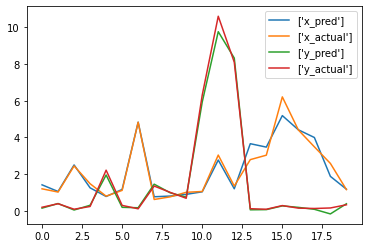

In [29]:
# plt.figure(figsize=(15,8))
plt.plot([i for i in range(len(best_preds))], best_preds[:,0],label=['x_pred'])
plt.plot([i for i in range(len(best_preds))], y_test.x, label = ['x_actual'])
plt.plot([i for i in range(len(best_preds))], best_preds[:,1],label=['y_pred'])
plt.plot([i for i in range(len(best_preds))], y_test.y, label = ['y_actual'])
plt.legend();

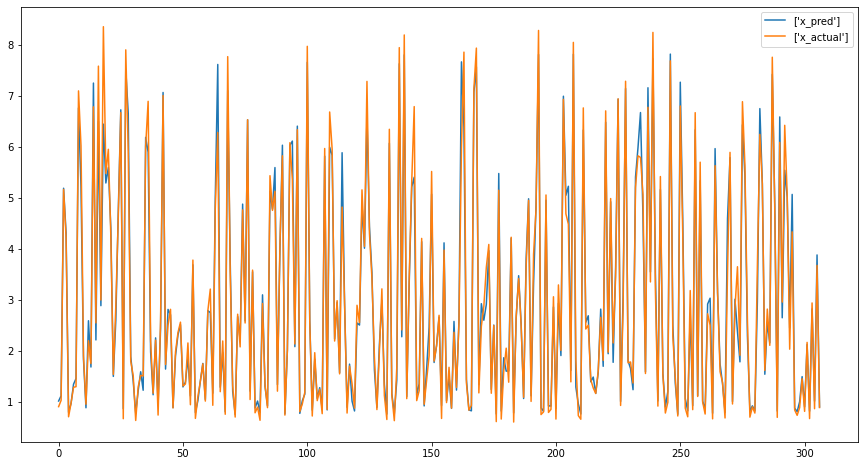

In [30]:
train_preds = model.predict(x_train)

plt.figure(figsize=(15,8))
plt.plot([i for i in range(len(train_preds))], train_preds[:,0],label=['x_pred'])
plt.plot([i for i in range(len(train_preds))], y_train.x, label = ['x_actual'])
plt.legend();

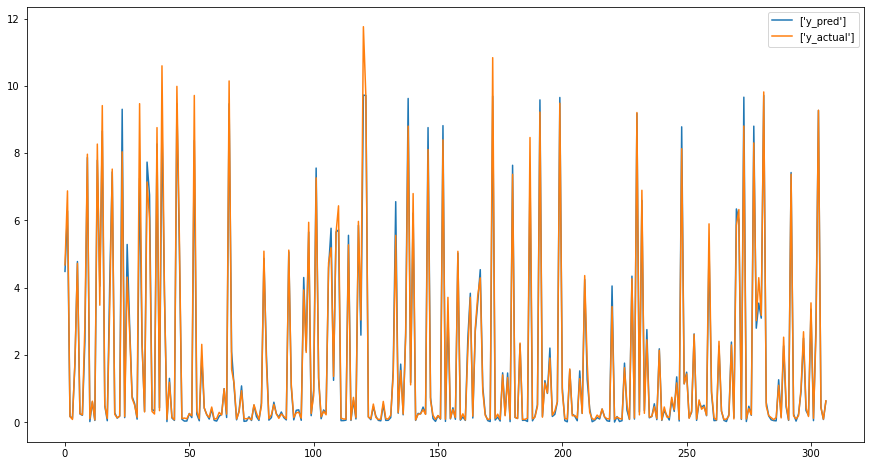

In [31]:
plt.figure(figsize=(15,8))
plt.plot([i for i in range(len(train_preds))], train_preds[:,1],label=['y_pred'])
plt.plot([i for i in range(len(train_preds))], y_train.y, label = ['y_actual'])
plt.legend();

### Predict for missing values on original data

In [32]:
df = pd.read_csv("https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv")

In [33]:
df['sin'] = df['t'].apply(lambda x: np.sin(x))
df['cos'] = df['t'].apply(lambda x: np.cos(x))
df['tan'] = df['t'].apply(lambda x: np.tan(x))

In [34]:
df['x'] = df['x'].apply(lambda x: np.nan if x == "-" else x)
df['y'] = df['y'].apply(lambda x: np.nan if x == "-" else x)
scaler = StandardScaler()
df[['t','sin','cos','tan']] = scaler.fit_transform(df[['t','sin','cos','tan']])

In [35]:
missing_vals = df.loc[(df['x'].isna() | df['y'].isna())].copy()
missing_vals.head()

,t,x,y,sin,cos,tan
0,-1.731185,NaN,0.5759052335487023,-0.041970,1.339541,-0.008990
1,-1.729453,NaN,NaN,-0.027679,1.339470,-0.008727
2,-1.727721,1.1159124144549086,NaN,-0.013389,1.339260,-0.008463
3,-1.725989,NaN,NaN,0.000898,1.338909,-0.008199
5,-1.722525,NaN,NaN,0.029457,1.337786,-0.007671


In [36]:
x_train_full = pd.concat([x_train,x_test])
y_train_full = pd.concat([y_train, y_test])

In [37]:
x_train_full

,t,sin,cos,tan
548,-0.852021,-1.112518,0.926125,-0.067695
1231,0.318332,-0.445920,1.309510,-0.057118
285,-1.302683,0.328034,-1.394999,-0.057637
1689,1.103136,-1.406920,-0.581939,-0.020177
613,-0.740640,-0.301465,1.338975,-0.055646
1968,1.581216,0.972821,0.898210,-0.038582
761,-0.487035,1.304908,0.289932,0.001352
772,-0.468186,1.334453,0.138225,0.047836
398,-1.109053,-1.146860,-0.988798,-0.038341
1873,1.418429,-0.253808,1.345398,-0.055177


In [38]:
best_model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.004797633583067918),
              metrics=[tf.keras.losses.mae,tf.keras.losses.mse]
             )

history = best_model.fit(x_train_full, 
          y_train_full, 
          epochs = 300, 
          callbacks = [create_model_checkpoint("best_imputation_model")],
          validation_data = (x_train_full, y_train_full),
          batch_size = 32
         )

Epoch 1/300
11/11 [==============================] - 0s 33ms/step - loss: 0.5241 - mean_absolute_error: 0.5241 - mean_squared_error: 0.9931 - val_loss: 0.4110 - val_mean_absolute_error: 0.4110 - val_mean_squared_error: 0.6149
Epoch 2/300
11/11 [==============================] - 0s 25ms/step - loss: 0.3790 - mean_absolute_error: 0.3790 - mean_squared_error: 0.4944 - val_loss: 0.3302 - val_mean_absolute_error: 0.3302 - val_mean_squared_error: 0.3590
Epoch 3/300
11/11 [==============================] - 0s 25ms/step - loss: 0.3150 - mean_absolute_error: 0.3150 - mean_squared_error: 0.3043 - val_loss: 0.2786 - val_mean_absolute_error: 0.2786 - val_mean_squared_error: 0.2301
Epoch 4/300
11/11 [==============================] - 0s 26ms/step - loss: 0.2546 - mean_absolute_error: 0.2546 - mean_squared_error: 0.2087 - val_loss: 0.2194 - val_mean_absolute_error: 0.2194 - val_mean_squared_error: 0.1596
Epoch 5/300
11/11 [==============================] - 0s 25ms/step - loss: 0.2172 - mean_absolute

11/11 [==============================] - 0s 562us/step - loss: 0.1813 - mean_absolute_error: 0.1813 - mean_squared_error: 0.1112 - val_loss: 0.1802 - val_mean_absolute_error: 0.1802 - val_mean_squared_error: 0.1104
Epoch 27/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1776 - mean_absolute_error: 0.1776 - mean_squared_error: 0.1076 - val_loss: 0.1701 - val_mean_absolute_error: 0.1701 - val_mean_squared_error: 0.1039
Epoch 28/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1805 - mean_absolute_error: 0.1805 - mean_squared_error: 0.1093 - val_loss: 0.1704 - val_mean_absolute_error: 0.1704 - val_mean_squared_error: 0.1043
Epoch 29/300
11/11 [==============================] - 0s 507us/step - loss: 0.1788 - mean_absolute_error: 0.1788 - mean_squared_error: 0.1107 - val_loss: 0.1742 - val_mean_absolute_error: 0.1742 - val_mean_squared_error: 0.1069
Epoch 30/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1728 - mean_absolute_error: 0

11/11 [==============================] - 0s 2ms/step - loss: 0.1790 - mean_absolute_error: 0.1790 - mean_squared_error: 0.1058 - val_loss: 0.1711 - val_mean_absolute_error: 0.1711 - val_mean_squared_error: 0.1069
Epoch 60/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - mean_squared_error: 0.1080 - val_loss: 0.1629 - val_mean_absolute_error: 0.1629 - val_mean_squared_error: 0.1021
Epoch 61/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1694 - mean_absolute_error: 0.1694 - mean_squared_error: 0.1079 - val_loss: 0.1670 - val_mean_absolute_error: 0.1670 - val_mean_squared_error: 0.1021
Epoch 62/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1747 - mean_absolute_error: 0.1747 - mean_squared_error: 0.1047 - val_loss: 0.1661 - val_mean_absolute_error: 0.1661 - val_mean_squared_error: 0.1014
Epoch 63/300
11/11 [==============================] - 0s 26ms/step - loss: 0.1691 - mean_absolute_error: 0.16

11/11 [==============================] - 0s 2ms/step - loss: 0.1775 - mean_absolute_error: 0.1775 - mean_squared_error: 0.1066 - val_loss: 0.1670 - val_mean_absolute_error: 0.1670 - val_mean_squared_error: 0.1029
Epoch 93/300
11/11 [==============================] - 0s 607us/step - loss: 0.1757 - mean_absolute_error: 0.1757 - mean_squared_error: 0.1116 - val_loss: 0.1718 - val_mean_absolute_error: 0.1718 - val_mean_squared_error: 0.1090
Epoch 94/300
11/11 [==============================] - 0s 3ms/step - loss: 0.1681 - mean_absolute_error: 0.1681 - mean_squared_error: 0.1046 - val_loss: 0.1694 - val_mean_absolute_error: 0.1694 - val_mean_squared_error: 0.1029
Epoch 95/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1689 - mean_absolute_error: 0.1689 - mean_squared_error: 0.1036 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673 - val_mean_squared_error: 0.1033
Epoch 96/300
11/11 [==============================] - 0s 1ms/step - loss: 0.1704 - mean_absolute_error: 0.1

11/11 [==============================] - 0s 2ms/step - loss: 0.1701 - mean_absolute_error: 0.1701 - mean_squared_error: 0.1052 - val_loss: 0.1676 - val_mean_absolute_error: 0.1676 - val_mean_squared_error: 0.1041
Epoch 129/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1687 - mean_absolute_error: 0.1687 - mean_squared_error: 0.1050 - val_loss: 0.1731 - val_mean_absolute_error: 0.1731 - val_mean_squared_error: 0.1042
Epoch 130/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1699 - mean_absolute_error: 0.1699 - mean_squared_error: 0.1060 - val_loss: 0.1616 - val_mean_absolute_error: 0.1616 - val_mean_squared_error: 0.1019
Epoch 131/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1715 - mean_absolute_error: 0.1715 - mean_squared_error: 0.1050 - val_loss: 0.1723 - val_mean_absolute_error: 0.1723 - val_mean_squared_error: 0.1046
Epoch 132/300
11/11 [==============================] - 0s 510us/step - loss: 0.1746 - mean_absolute_error:

11/11 [==============================] - 0s 2ms/step - loss: 0.1747 - mean_absolute_error: 0.1747 - mean_squared_error: 0.1045 - val_loss: 0.1793 - val_mean_absolute_error: 0.1793 - val_mean_squared_error: 0.1062
Epoch 164/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1796 - mean_absolute_error: 0.1796 - mean_squared_error: 0.1066 - val_loss: 0.1682 - val_mean_absolute_error: 0.1682 - val_mean_squared_error: 0.1028
Epoch 165/300
11/11 [==============================] - 0s 406us/step - loss: 0.1718 - mean_absolute_error: 0.1718 - mean_squared_error: 0.1043 - val_loss: 0.1635 - val_mean_absolute_error: 0.1635 - val_mean_squared_error: 0.0983
Epoch 166/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - mean_squared_error: 0.1070 - val_loss: 0.1705 - val_mean_absolute_error: 0.1705 - val_mean_squared_error: 0.1067
Epoch 167/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1692 - mean_absolute_error:

11/11 [==============================] - 0s 2ms/step - loss: 0.1640 - mean_absolute_error: 0.1640 - mean_squared_error: 0.1054 - val_loss: 0.1615 - val_mean_absolute_error: 0.1615 - val_mean_squared_error: 0.1034
Epoch 199/300
11/11 [==============================] - 0s 806us/step - loss: 0.1616 - mean_absolute_error: 0.1616 - mean_squared_error: 0.1014 - val_loss: 0.1618 - val_mean_absolute_error: 0.1618 - val_mean_squared_error: 0.1012
Epoch 200/300
11/11 [==============================] - 0s 3ms/step - loss: 0.1636 - mean_absolute_error: 0.1636 - mean_squared_error: 0.1049 - val_loss: 0.1639 - val_mean_absolute_error: 0.1639 - val_mean_squared_error: 0.1030
Epoch 201/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1757 - mean_absolute_error: 0.1757 - mean_squared_error: 0.1082 - val_loss: 0.1635 - val_mean_absolute_error: 0.1635 - val_mean_squared_error: 0.1026
Epoch 202/300
11/11 [==============================] - 0s 1ms/step - loss: 0.1693 - mean_absolute_error:

11/11 [==============================] - 0s 1ms/step - loss: 0.1745 - mean_absolute_error: 0.1745 - mean_squared_error: 0.1062 - val_loss: 0.1809 - val_mean_absolute_error: 0.1809 - val_mean_squared_error: 0.1055
Epoch 235/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1701 - mean_absolute_error: 0.1701 - mean_squared_error: 0.1059 - val_loss: 0.1691 - val_mean_absolute_error: 0.1691 - val_mean_squared_error: 0.1042
Epoch 236/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1687 - mean_absolute_error: 0.1687 - mean_squared_error: 0.1041 - val_loss: 0.1599 - val_mean_absolute_error: 0.1599 - val_mean_squared_error: 0.0995
Epoch 237/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1664 - mean_absolute_error: 0.1664 - mean_squared_error: 0.1056 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673 - val_mean_squared_error: 0.1036
Epoch 238/300
11/11 [==============================] - ETA: 0s - loss: 0.1565 - mean_absolute_error: 0.156

Epoch 269/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1625 - mean_absolute_error: 0.1625 - mean_squared_error: 0.1017 - val_loss: 0.1610 - val_mean_absolute_error: 0.1610 - val_mean_squared_error: 0.1029
Epoch 270/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1640 - mean_absolute_error: 0.1640 - mean_squared_error: 0.1047 - val_loss: 0.1645 - val_mean_absolute_error: 0.1645 - val_mean_squared_error: 0.1034
Epoch 271/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1627 - mean_absolute_error: 0.1627 - mean_squared_error: 0.1018 - val_loss: 0.1635 - val_mean_absolute_error: 0.1635 - val_mean_squared_error: 0.1045
Epoch 272/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - mean_squared_error: 0.1032 - val_loss: 0.1698 - val_mean_absolute_error: 0.1698 - val_mean_squared_error: 0.1047
Epoch 273/300
11/11 [==============================] - 0s 2ms/step - loss: 0.1704 - mean_abs

In [39]:
best_model = tf.keras.models.load_model('model_experiments/best_imputation_model/')
best_model.evaluate(x_train_full, y_train_full)

11/11 [==============================] - 0s 251us/step - loss: 0.1551 - mean_absolute_error: 0.1551 - mean_squared_error: 0.0990


[0.15514272451400757, 0.15514272451400757, 0.09902551770210266]

In [40]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [41]:
for i in range(3):
    print(model.layers[i].get_config())

{'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 150, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 20, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 2, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_n

In [42]:
missing_vals_pred = best_model.predict(missing_vals[['t','sin','cos','tan']])
missing_x_pred,missing_y_pred = missing_vals_pred[:,0], missing_vals_pred[:,1]
missing_vals['x_pred'] = missing_x_pred
missing_vals['y_pred'] = missing_y_pred

In [43]:
missing_vals.x = missing_vals.x.astype('float32')
missing_vals.y = missing_vals.y.astype('float32')

### Plotting the final predictions

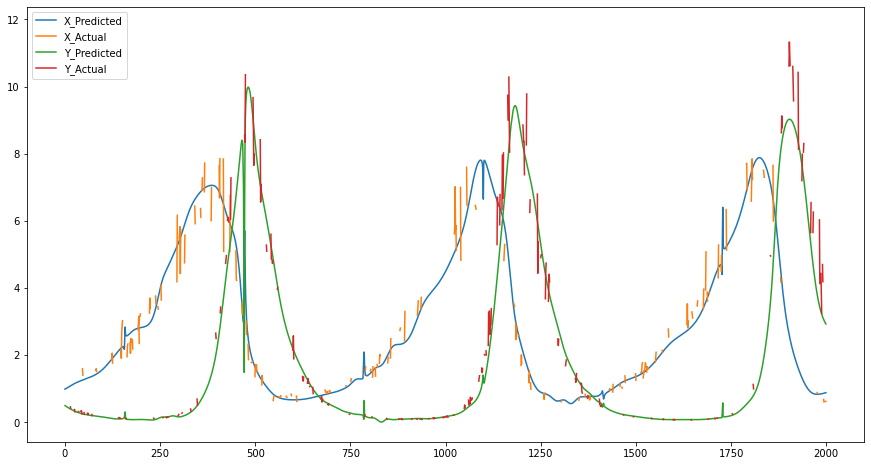

In [44]:
plt.figure(figsize=(15,8))
plt.plot(missing_vals.index, missing_vals.x_pred, label = "X_Predicted")
plt.plot(missing_vals.index, missing_vals.x, label = "X_Actual")
plt.plot(missing_vals.index, missing_vals.y_pred, label = "Y_Predicted")
plt.plot(missing_vals.index, missing_vals.y, label = "Y_Actual")
plt.legend();

<h3>Questions</h3><br>
Please answer the questions about the exercise below as a text cell. A few sentences answer per question is enough, no need to write a long essay.

a) Roughly, how many parameters does the neural network you defined above have? How did you estimate that number?<br>
b) How does changing the batch size affect the optimization procedure?<br>
c) What optimizer did you choose and why? Explain its most important hyperparameters.<br>
d) What difficulties did you face when processing the dataset? How did you resolve them?<br>
e) How did you find the hyperparameters that gave you the best result? What would you have done if you had more time?<br>
f) In this exercise, we trained an MLP to regress the data from a single time point. This corresponds to assuming the source function is markovian. What would we do differently if the function under study were non-markovian?<br>
g) In this exercise, we did not check for overfitting. How would you change the code above to test for that possibility?<br>

<h3> Answers </h3>
<br>
<ul>
    <li>a) The best model has 4610 parameters as seen from the model summary. It was not estimated, but rather the final result achieved after hyperparameter tuning</li>
    <li>b) Using a large batch size causes the model to overfit as model weights are updated based on the error over the entire dataset. A smaller batch size means model weights are updated after each batch based on the error calculated on that batch.</li>
    <li>c) Adam optimizer. It combines the advantages of RMSprop (learning rate decay) with stochastic grad descent with momentum (escape from local minima). Learning rate is often the most important hyperparam to consider, but we could also consider other hyperparams like beta1 and beta2 for moment estimation</li>
    <li>d) When it came to processing the timesteps, there were inconsistent time intervals between each sequence regardless of window size. It was resolved by reframing the problem from a sequence modelling problem to a regression problem based on individual timesteps</li>
    <li>e) The optimal hyperparameters were found by using the keras-tuner library performing a randomized search over the entire hyperparameter space</li>
    <li>f) If the function was non-markovian (the prev time step affects the value of the next time step), we would need to consider a sequential model that takes in values over a window size (i.e [t0,t1,t2] ,[t1,t2,t3], ...</li>
    <li>g) By using L2 Regularization or batch dropout</li>
</ul>